In [51]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import os.path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Criar uma lista com os caminhos dos arquivos de treino, teste e validação
train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))


In [31]:
def proc_img(filepaths):
    """Criar um dataframe com os caminhos dos arquivos e suas respectivas labels"""
    labels = [filepath.parts[-2] if len(filepath.parts) >= 2 else "unknown" for filepath in filepaths]
    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    label_series = pd.Series(labels, name='Label')
    df = pd.concat([filepath_series, label_series], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [32]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [33]:
print(f"Tamanho dos dados de treino: {train_df.shape}")
print(f"Tamanho dos dados de teste: {test_df.shape}")
print(f"Tamanho dos dados de validação: {val_df.shape}")

Tamanho dos dados de treino: (2855, 2)
Tamanho dos dados de teste: (340, 2)
Tamanho dos dados de validação: (340, 2)


In [19]:
# Como os arquivos já salva o rótulo, usamos eles para criar o rótulo para cada imagem e seu caminho
print('-- Conjunto de Treinamento --\n')
print(f'Número de imagens: {train_df.shape[0]}\n')
print(f'Número de rótulos diferentes: {len(train_df.Label.unique())}\n')
print(f'Rótulos: {train_df.Label.unique()}')

-- Conjunto de Treinamento --

Número de imagens: 2855

Número de rótulos diferentes: 36

Rótulos: ['jalepeno' 'watermelon' 'spinach' 'pomegranate' 'pear' 'cabbage'
 'paprika' 'lemon' 'corn' 'carrot' 'sweetcorn' 'bell pepper' 'peas'
 'banana' 'cucumber' 'onion' 'tomato' 'kiwi' 'cauliflower' 'eggplant'
 'capsicum' 'pineapple' 'beetroot' 'garlic' 'potato' 'turnip' 'ginger'
 'lettuce' 'grapes' 'sweetpotato' 'soy beans' 'orange' 'chilli pepper'
 'apple' 'raddish' 'mango']


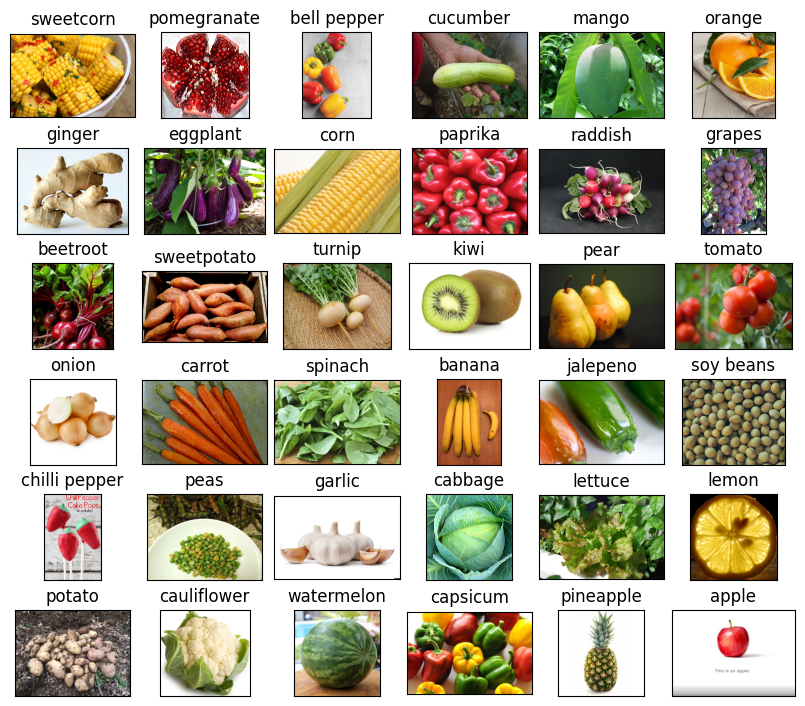

In [ ]:
# Criar Dataframe com imagens de cada rótulo
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [35]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', # Caminho da imagem
    y_col='Label', # Rótulo da imagem
    target_size=(224, 224), # Tamanho da imagem no caso 224x224 pixels
    color_mode='rgb', # Tipo de cor da imagem (colorida)
    class_mode='categorical', # Tipo de classificação (categórica)
    batch_size=32, # Tamanho do lote (num. de imagens carregar por vez)
    shuffle=True, # Embaralhar as imagens
    seed=0,
    rotation_range=30, # Grau de rotação aleatória (Evitar overfitting)
    zoom_range=0.15, # Zoom aleatório
    width_shift_range=0.2, # Deslocamento horizontal
    height_shift_range=0.2, # Deslocamento vertical
    shear_range=0.15, # Cisalhamento (distorce a imagem em um ângulo) 
    horizontal_flip=True, # Espelhamento
    fill_mode="nearest" # Preenchimento automatico
)

Found 2855 validated image filenames belonging to 36 classes.


In [37]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [38]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [39]:
# Carregando Modelo pre-treinado

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Treino do Modelo

In [40]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.3329 - loss: 2.5754 - val_accuracy: 0.8676 - val_loss: 0.4109
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 86s 959ms/step - accuracy: 0.8206 - loss: 0.6229 - val_accuracy: 0.8941 - val_loss: 0.3180
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 937ms/step - accuracy: 0.8879 - loss: 0.3465 - val_accuracy: 0.9294 - val_loss: 0.2254
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 88s 976ms/step - accuracy: 0.9349 - loss: 0.2220 - val_accuracy: 0.9265 - val_loss: 0.2037
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9628 - loss: 0.1388 - val_accuracy: 0.9441 - val_loss: 0.1649


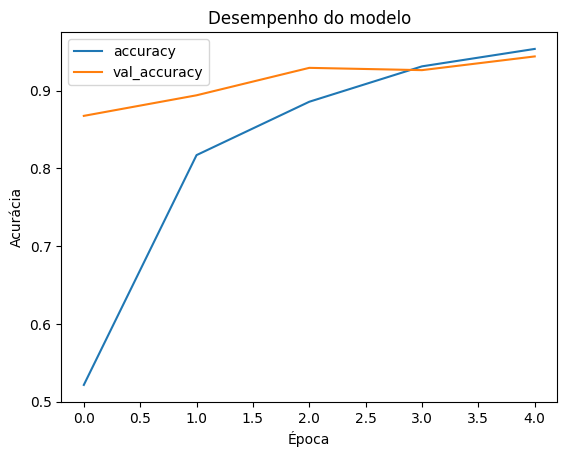

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Desempenho do modelo")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.show()

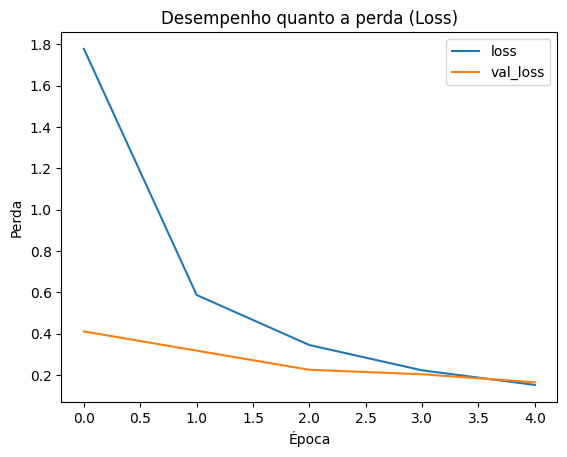

In [45]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Desempenho quanto a perda (Loss)")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.show()

# 2 - Testando os resultados

In [46]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# mapear rótulos
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [49]:
acc = accuracy_score(y_test, pred)
print(f'Acurácia nos dados de teste: {100*acc:.2f}%')


Acurácia nos dados de teste: 94.41%


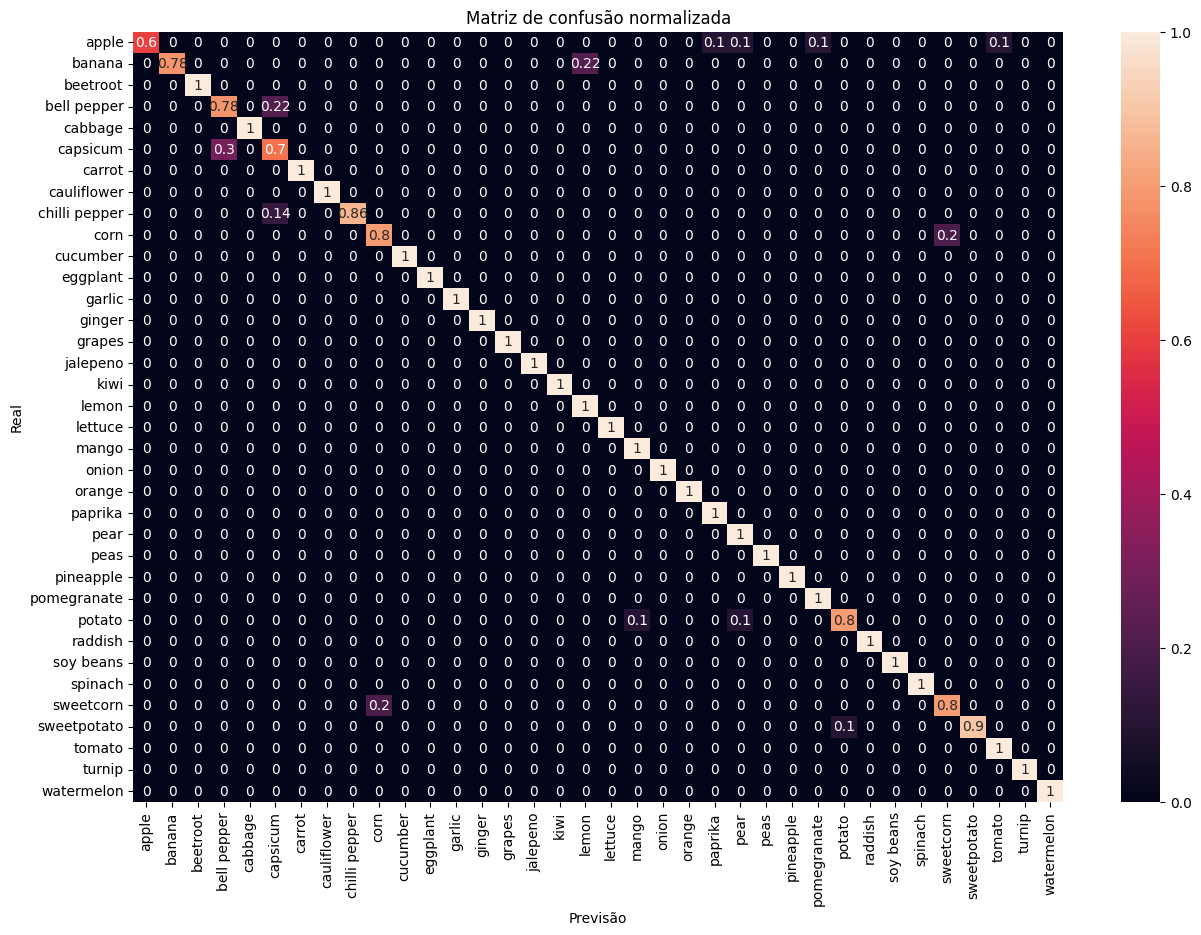

In [ ]:
# Análise matriz de confusão
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Matriz de confusão normalizada')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()